# __Validations for single star ACA tracker simulator__

In [38]:
from __future__ import division
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from Quaternion import Quat
from astropy.table import Table
import Ska.Numpy
from Ska.engarchive import fetch_sci as fetch
from mica.archive.aca_l0 import get_l0_images, get_slot_data
from Chandra.Time import DateTime
from Ska.Matplotlib import plot_cxctime
import cxotime
from chandra_aca.aca_image import ACAImage
from kadi import events
import mica.starcheck
from chandra_aca.transform import pixels_to_yagzag, yagzag_to_pixels, mag_to_count_rate, count_rate_to_mag
from Ska.quatutil import yagzag2radec, radec2yagzag

In [39]:
# local imports:
import sys
sys.path.append(".")
import aca_simulate as sim
reload(sim)
from aca_simulate import ImgList

In [40]:
def get_telem(cat, slot):
    ok = (cat['slot'] == slot) * ((cat['type'] == 'BOT') + (cat['type'] == 'GUI'))
    yag, zag = cat['yang'][ok][0], cat['zang'][ok][0]
    mag, maxmag = cat['mag'][ok][0], cat['maxmag'][ok][0]
    return yag, zag, mag, maxmag


def as_array(attr, imgs):
    out = np.array([getattr(img, attr) for img in imgs])
    return out


def plot_star(star, c32=True):
    plt.imshow(star, interpolation='none', cmap='hot', vmin = -100, vmax=2300, origin='lower')
    plt.colorbar()
    plt.hlines(np.arange(0.5, 7.5), -0.5, 7.5, colors='y', linestyles='dotted')
    plt.vlines(np.arange(0.5, 7.5), -0.5, 7.5, colors='y', linestyles='dotted')
    if c32:
        c32 = np.array([1, 2, 2, 6, 6, 7, 7, 6, 6, 2, 2, 1, 1]) - 0.5
        r32 = np.array([2, 2, 1, 1, 2, 2, 6, 6, 7, 7, 6, 6, 2]) - 0.5
        plt.plot(c32, r32, '-', lw=2, color='w')
    plt.xlim(-0.5, 7.5)
    plt.ylim(-0.5, 7.5)
    plt.ylabel('Row')
    plt.xlabel('Column')
    plt.title('(ROW0, COL0) = ({:.0f}, {:.0f})'.format(row0, col0))
    return


def plot_set(imgs, start, vmin=-10, vmax=2000, num=4, grid6x6=False):
    for i in np.arange(start, start + num):
        plt.subplot(1, num, i - start + 1)
        plt.imshow(imgs[i], interpolation='none', origin='lower',
                   cmap='hot', vmin=vmin, vmax=vmax)
        if grid6x6:
            plt.hlines(np.arange(0.5, 5.5), -0.5, 5.5, colors='y', linestyles='dotted')
            plt.vlines(np.arange(0.5, 5.5), -0.5, 5.5, colors='y', linestyles='dotted')
        plt.xlabel('Column (px)')
        plt.ylabel('Row (px)')
    return


def centroids(img):
    img = np.array(img[1:7, 1:7])
    rw, cw = np.mgrid[0:6, 0:6] + 0.5
    img[[0, 0, 5, 5], [0, 5, 0, 5]] = 0.
    norm = np.sum(img)
    r = np.sum(rw * img) / norm
    c = np.sum(cw * img) / norm
    return r, c


class ObcAca(object):
    def __init__(self, start, stop, slot):
        self.yags = fetch.Msid('aoacyan{}'.format(slot), start, stop)
        self.zags = fetch.Msid('aoaczan{}'.format(slot), start, stop)
        self.funcs = fetch.Msid('aoacfct{}'.format(slot), start, stop)
        self.seqs = fetch.Msid('aoacaseq'.format(slot), start, stop)
        self.mags = fetch.Msid('aoacmag{}'.format(slot), start, stop)
        self.defpix = fetch.Msid('aoacidp{}'.format(slot), start, stop)
        self.multstars = fetch.Msid('aoacims{}'.format(slot), start, stop)
        self.t_aca = fetch.Msid('aach1t', start, stop)
        self.t_aca = np.mean(self.t_aca.vals)
        self.ok = (self.yags.vals > -3200) & (self.zags.vals > -3200)
        self.imgs = get_l0_images(start, stop, slot=slot,
                                   columns=['IMGROW0', 'IMGCOL0', 'BGDAVG', 'TIME'])
        self.row0s = as_array('IMGROW0', self.imgs)
        self.col0s = as_array('IMGCOL0', self.imgs)
        self.bgdavgs = as_array('BGDAVG', self.imgs)
        self.times = as_array('TIME', self.imgs)
        
    def __getattr__(imgs, attr):
        return np.array([getattr(img, attr) for img in imgs])

In [41]:
FWHM = 1.8
GAIN = 5.
INTEG = 1.696

<img src='ACAImage-coordinates.jpg'>

##Obsid 8008##

In [42]:
obsid = 8008
d = events.dwells.filter(obsid=obsid)[0]
slot = 6
obc = ObcAca(d.start, d.stop, slot=slot)
sc = mica.starcheck.get_starcheck_catalog_at_date(d.start)
#quat = Quat([sc['manvr']['target_Q{}'.format(i)][0] for i in (1, 2, 3, 4)])
cat = sc['cat']
obs = sc['obs']
dither = {'dither_y_amp': obs['dither_y_amp'], 'dither_z_amp': obs['dither_z_amp'],
          'dither_y_period': obs['dither_y_period'], 'dither_z_period': obs['dither_z_period'],
          'dither_y_phase': 0., 'dither_z_phase': 0.}

In [43]:
atts = fetch.MSIDset(['aoattqt*'], d.start, d.stop)
quat = Quat([atts['aoattqt{}'.format(i + 1)].vals[0] for i in range(4)])

In [44]:
yag, zag, mag, maxmag = get_telem(cat, slot)
print('Slot {}, guiding on star with:'.format(slot))
print('yag = {:.0f}, zag = {:.0f}, mag = {:.3f}, maxmag = {:.3f}'.format(yag, zag, mag, maxmag))

Slot 6, guiding on star with:
yag = 890, zag = -1600, mag = 8.641, maxmag = 10.141


In [45]:
obc.mags.times[1] - obc.mags.times[0], obc.mags.times[1]

(1.0250000357627869, 284100554.51001441)

In [46]:
obc.times[1] - obc.times[0], obc.times[0]

(2.0500001311302185, 284100554.68701398)

In [47]:
atts['aoattqt1'].times[0] - obc.times[0], atts['aoattqt1'].times[0]

(-1.2019996047019958, 284100553.48501438)

### Simulate a single star ###

* Simulation of star corresponding to the first frame in Obsid 8008, and comparison with the telemetry.
* Star is modeled as a 2-D Gaussian with FWHM = 1.8.
* ACA readout window is defined with row0, col0 (between -511 and 512) and sz (6 or 8 pixels).
* Star location in ACA readout window is derived from star's ra, dec and spacecraft attitude quaternion.
* Mouse-bitten 6x6 region is used to convert between counts and mags.

__Issues__

* Magnitude in telemetry: computed from 32 pixels or 8x8?
* FWHM of a typical ACA star, FWHM = 1.8? Appears that the simulated star images are too peaked and FWHM ~ 2.5px would be more appropriate given the telemetry.

In [48]:
reload(sim)
sz = 8
row0 = obc.row0s[0]
col0 = obc.col0s[0]
# OBC
star_obc = np.zeros((8, 8))
star_obc[1:-1, 1:-1] = obc.imgs[0]
# Simulation 1: star parameters from telemetry
ra1, dec1 = yagzag2radec(obc.yags.vals[0] / 3600., obc.zags.vals[0] / 3600., quat)
mag1 = obc.mags.vals[0]
star1 = sim.simulate_star(quat, ra1, dec1, mag1, row0, col0, sz)
# Simulation 2: star params (yag, zag, mag, quat) from catalog
ra2, dec2 = yagzag2radec(yag / 3600., zag / 3600., quat)
star2 = sim.simulate_star(quat, ra2, dec2, mag, row0, col0, sz)

OBC (left): (r, c) = (3.239, 3.387)
    Counts - 32 * bgdavg = 8578.03125
    Mag: 8.641
Simulation 1 (middle): (r, c) = (3.238, 3.390)
    Counts: 8659
    Mag: 8.606
    dyag = 0.000 arcsec, dzag = 0.000 arcsec
    dr = -0.001 px ,  dc = 0.003 px
Simulation 2 (right): (r, c) = (2.645, 1.793)
    Counts: 8392
    Mag: 8.640
    dyag = 2.925 arcsec, dzag = -7.975 arcsec
    dr = -0.594 px ,  dc = -1.594 px


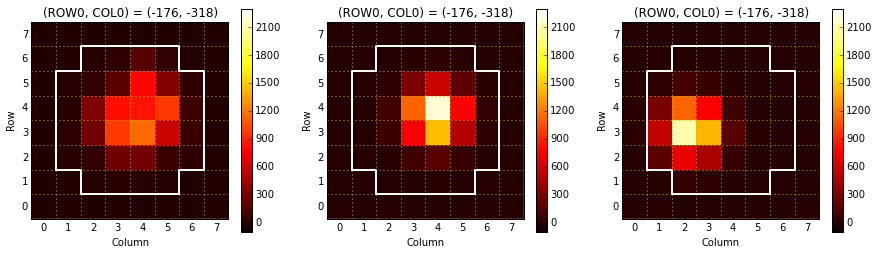

In [49]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plot_star(star_obc - obc.bgdavgs[0])
plt.subplot(1, 3, 2)
plot_star(star1)
plt.subplot(1, 3, 3)
plot_star(star2)
row_obc, col_obc = yagzag_to_pixels(obc.yags.vals[0], obc.zags.vals[0])
r_obc = row_obc - row0
c_obc = col_obc - col0
row1_sim, col1_sim = yagzag_to_pixels(yag, zag)
r_sim1, c_sim1 = centroids(star1)
r_sim2, c_sim2 = centroids(star2)

print('OBC (left): (r, c) = ({:.3f}, {:.3f})'.format(r_obc, c_obc))
print('    Counts - 32 * bgdavg = {}'.format(np.sum(obc.imgs[0]) - 32 * obc.bgdavgs[0]))
print('    Mag: {}'.format(mag))

print('Simulation 1 (middle): (r, c) = ({:.3f}, {:.3f})'.format(r_sim1, c_sim1))
print('    Counts: {:.0f}'.format(np.float(np.sum(star1))))
print('    Mag: {:.3f}'.format(np.float(count_rate_to_mag(np.sum(star1) * GAIN / INTEG))))
print('    dyag = {:.3f} arcsec, dzag = {:.3f} arcsec'.format(0., 0.))
print('    dr = {:.3f} px ,  dc = {:.3f} px'.format(r_sim1 - r_obc, c_sim1 - c_obc))

print('Simulation 2 (right): (r, c) = ({:.3f}, {:.3f})'.format(r_sim2, c_sim2))
print('    Counts: {:.0f}'.format(np.float(np.sum(star2))))
print('    Mag: {:.3f}'.format(np.float(count_rate_to_mag(np.sum(star2) * GAIN / INTEG))))
print('    dyag = {:.3f} arcsec, dzag = {:.3f} arcsec'.format(yag - obc.yags.vals[0], zag - obc.zags.vals[0]))
print('    dr = {:.3f} px ,  dc = {:.3f} px'.format(r_sim2 - r_obc, c_sim2 - c_obc))

__Figure.__ Left: OBC telemetry. Middle: Star image simulated using OBC's yag, zag, mag, quat. Right: Star image simulated using catalog yag, zag, mag, quat. Simulated stars appear to be too 'peaked', replace FWHM=1.8 with FWHM~2.5? Simulation using catalog yag, zag, mag, quat (right) results in (dyag, dzag) = (2.9, -8.0) arcsec or (dr, dc) = (-0.6, -1.6) px with respect to the telemetered values (left). Could be due to pointing uncertainties and/or time shift between the telemetry?

### Simulate stars within 40 arcsec from the position of the star of interest### 

* Based on initial (catalog) values of yag and zag, and dither, compute time evolution of yag, zag coordinates (true_yags, true_zags).
* Step from each (true_yag_i, true_zag_i) to (true_yag_i+1, true_zag_i+1), find maneuvers corresponding to these transitions, dq_i, and compute time evolution of true spacecraft attitude (quats).
* Size of the simulated star field (30px) is derived as the sum of
     * 2 x 40 arcsec = 16px,
     * 8px to properly simulate spoiler stars with max separation of 40 arcsec
     * 6px due to dither.
* Using true_yags, true_zags and quats, find true RA and DEC of the spacecraft (true_ras, true_decs).
* Find all stars within 40 arcsec from each pair true_ras_i, true_decs_i (this will include also the star of interest). Simulate each star. Sum up all the stars and add dark background.
* ACA dark background is determined through kwargs argument dark: None (default, use the most recent), date, or 1024x1024 array. Dark background is scaled with temperature given by t_ccd (default None, no scaling). 

__Choose an observation with spoiler stars__<br>
See Obsid NONE2, https://icxc.cfa.harvard.edu/mp/mplogs/2015/JUL1015/oflsb/starcheck.html. To the right of star number 5 there is a faint 10.89 mag star in the center, and two spoiler star with mags 8.06 and 9.86.

<img src='stars_NONE2.png'>

In [50]:
reload(sim)
quat1 = Quat([280, 0.5, 201.675669])
yag1, zag1, mag1 = 1210.37, 995.98, 10.89
kwargs = {'nframes': 4, 'radius': 120., 'imgsize': 6, 'dither': dither, 'dark': '2015:200'}
stars1 = sim.simulate_star_field(quat1, yag1, zag1, mag1, **kwargs)
stars1.keys()

['quats',
 'true_yags',
 'true_zags',
 'true_rows',
 'true_ras',
 'imgs',
 'true_decs',
 'true_cols']

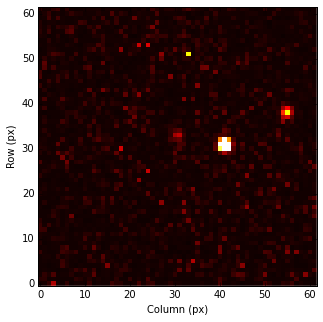

In [51]:
plt.figure(figsize=(8, 5))
plot_set(stars1['imgs'], start=0, num=1, vmax=1000)

__Dither pattern (back to Obsid 8008)__

In [52]:
reload(sim)
kwargs = {'nframes': 500, 'radius': 40., 'imgsize': 6, 'dither': dither, 'dark': d.start}
stars = sim.simulate_star_field(quat, yag, zag, mag, **kwargs)

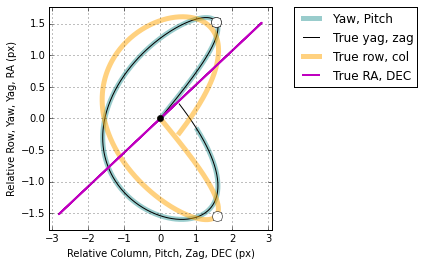

In [53]:
# Yag ~ Yaw ~ RA ~ *minus* column
# Zag ~ Pitch ~ *minus* DEC ~ row
plt.figure(figsize=(4, 4))

yaw = sim.calc_dither(np.arange(480) * 2.05,
                      dither['dither_y_amp'],
                      dither['dither_y_period'],
                      dither['dither_y_phase']) / 5.
pitch = sim.calc_dither(np.arange(480) * 2.05,
                        dither['dither_z_amp'],
                        dither['dither_z_period'],
                        dither['dither_z_phase']) / 5. 

relative_yags = np.array(stars['true_yags'] - stars['true_yags'][0]) / 5.
relative_zags = np.array(stars['true_zags'] - stars['true_zags'][0]) / 5.

relative_rows = np.array(stars['true_rows'] - stars['true_rows'][0])
relative_cols = np.array(stars['true_cols'] - stars['true_cols'][0])

relative_ras = np.array(stars['true_ras'] - stars['true_ras'][0]) * 3600 / 5.
relative_decs = np.array(stars['true_decs'] - stars['true_decs'][0]) * 3600 / 5.

plt.plot(pitch, yaw, label='Yaw, Pitch', color='teal', lw=5, alpha=0.4)
plt.plot(relative_zags, relative_yags, label='True yag, zag', color='k', lw=1)
plt.plot(relative_cols, relative_rows, label='True row, col', color='orange', lw=5, alpha=0.5)
plt.plot(relative_decs, relative_ras, label='True RA, DEC', color='m', lw=2)

plt.plot([0], [0], 'ok')
plt.plot([relative_zags[100], pitch[100], relative_cols[100]],
         [relative_yags[100], yaw[100], relative_rows[100]], 'ow', ms=10)
plt.legend(loc=(1.1, 0.64))
plt.margins(0.05)
plt.grid()
plt.xlabel("Relative Column, Pitch, Zag, DEC (px)")
plt.ylabel("Relative Row, Yaw, Yag, RA (px)");

__Figure.__ (Relative) True (yag, zag) and true (row, col) evolution due to dither defined with (Yaw, Pitch). Dots mark locations corresponding to the images displayed in the next two figures.

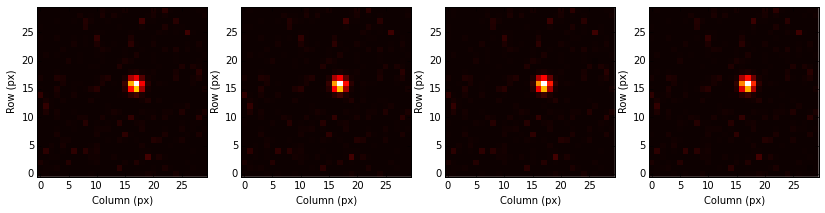

In [54]:
plt.figure(figsize=(14, 5))
plot_set(stars['imgs'], start=0)

__Figure.__ Simulated images corresponding to the first 4 time steps (black dot).

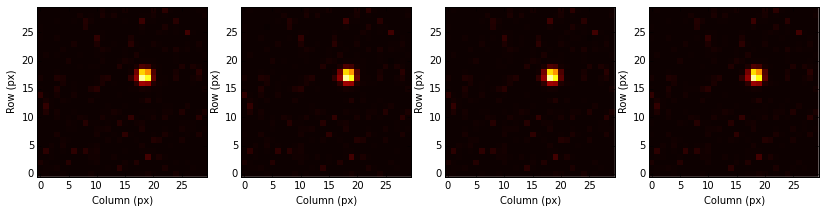

In [55]:
plt.figure(figsize=(14, 5))
plot_set(stars['imgs'], start=98)

__Figure.__ Simulated images corresponding to the first 4 time steps (yellow dots).

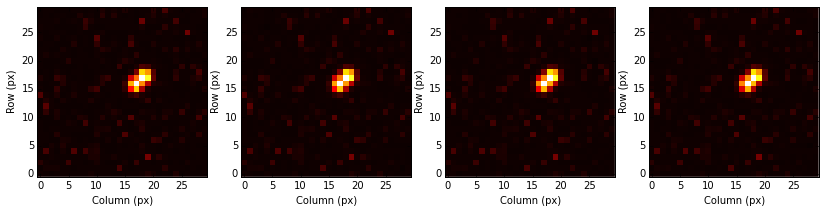

In [56]:
imgs_sum = [im1 + im2 for im1, im2 in zip(stars['imgs'][0:4], stars['imgs'][98:102])]
plt.figure(figsize=(14, 5))
plot_set(imgs_sum, start=0)

__Figure.__ Sum of the images corresponding to the locations marked with black and yellow dots. Star moved toward the _upper_ right corner: positive dCol, _positive_ dRow. From the dither pattern it was expected that the star will move towards the _lower_ right corner: positive dCol, _negative_ dRow. This can be 'fixed' by changing sign of delta yaw when computing dq steps (dy to -dy in line 248, aca_simulate.py) but I don't understant why this would work.

In [57]:
reload(sim)
from aca_simulate import ImgList
imgs_list = ImgList(stars['imgs'])

In [58]:
print('All row0s and col0s are the same:')
print(imgs_list.row0s.min(), imgs_list.row0s.max(), imgs_list.col0s.min(), imgs_list.col0s.max())

All row0s and col0s are the same:
(-188.0, -188.0, -331.0, -331.0)


In [59]:
print('Rows, cols representing centroids are not computed yet, they are initiated as -511:')
print(imgs_list.rows[:2], imgs_list.cols[:2])

Rows, cols representing centroids are not computed yet, they are initiated as -511:
(array([-511., -511.]), array([-511., -511.]))


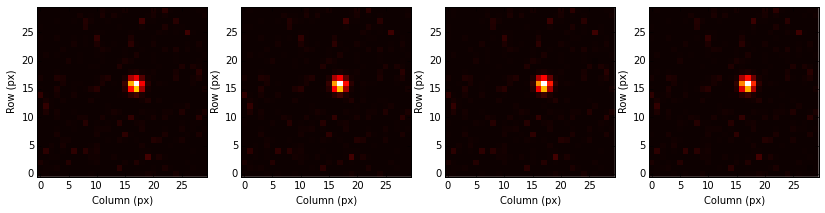

In [60]:
plt.figure(figsize=(14, 5))
plot_set(imgs_list, start=0)

__Figure.__ Same as above (the first 4 simulated images) but using an object defined as list of ACAImage objects.

### Star field simulator combined with star tracker###

In [61]:
reload(sim)
kwargs = {'nframes': 500, 'radius': 40., 'imgsize': 6, 'dither': dither, 'dark': d.start}
guide = sim.simulate_guide(quat, yag, zag, mag, **kwargs)

In [62]:
guide.keys()

['funcs',
 'dyags',
 'imgraws',
 'row0s',
 'dzags',
 'bgdavgs',
 'true_zags',
 'aca_yags',
 'col0s',
 'aca_zags',
 'aca_mags',
 'true_yags',
 'stars',
 'time']

In [63]:
print('Star has been tracked.')
print('Row0s, col0s have been updated for each image to reflect the lower left corner of 6x6 images:')
guide['row0s'].min(), guide['row0s'].max()

Star has been tracked.
Row0s, col0s have been updated for each image to reflect the lower left corner of 6x6 images:


(-176.0, -173.0)

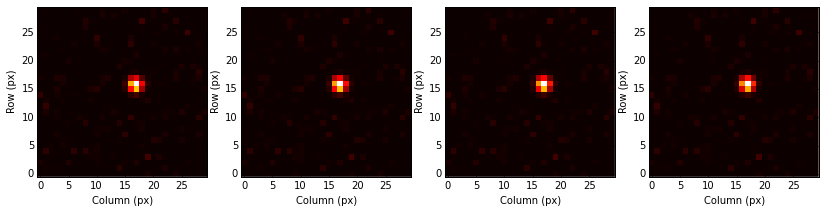

In [64]:
fig = plt.figure(figsize=(14, 5))
plot_set(guide['stars'], start=0)

__Figure.__ Dictionary guide contains key 'stars' which keeps original star field images.

(ROW0, COL0) = (-176.0, -319.0)
(ROW0, COL0) = (-176.0, -319.0)
(ROW0, COL0) = (-175.0, -317.0)
(ROW0, COL0) = (-175.0, -316.0)
(ROW0, COL0) = (-175.0, -317.0)
(ROW0, COL0) = (-175.0, -317.0)


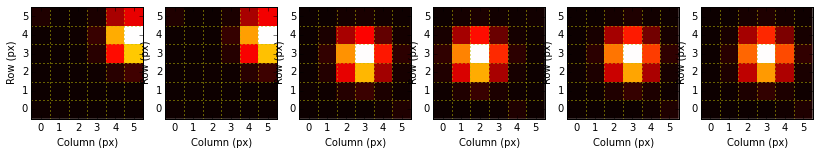

In [65]:
plt.figure(figsize=(14, 5))
start, num = 0, 6
plot_set(guide['imgraws'], start=start, num=num, grid6x6=True)
for ii in range(num):
    print('(ROW0, COL0) = ({}, {})'.format(guide['row0s'][ii + start], guide['col0s'][ii + start]))

__Figure.__ Dictionary guide contains key 'imgraws' which keeps 6x6 (8x8) images used while tracking and computing centroids. Keys 'row0s', 'col0s' contain values defining the ACA location of these images. Note the 2-3px offset between the 'true' centroid and simulated centroid inthe left-most image (image at t=0). This could be due to pointing errors, or an error on the order of imgsize/2 while simulating the star field.

In [66]:
print('Keys dyags (dzags) reflect difference between')
print('- true_yags/zags (derived from initial yag, zag, quat) and')
print('- aca_yags/zags (derived from simulated images)\n')
start = 0
for ii in range(num):
    print('(dyag, dzag) = ({:.1f}, {:.1f}) arcsec'.format(guide['dyags'][ii + start], guide['dzags'][ii + start]))

Keys dyags (dzags) reflect difference between
- true_yags/zags (derived from initial yag, zag, quat) and
- aca_yags/zags (derived from simulated images)

(dyag, dzag) = (-7.6, 11.3) arcsec
(dyag, dzag) = (-7.8, 11.2) arcsec
(dyag, dzag) = (-8.6, 12.6) arcsec
(dyag, dzag) = (-8.7, 12.7) arcsec
(dyag, dzag) = (-9.0, 12.6) arcsec
(dyag, dzag) = (-9.2, 12.6) arcsec


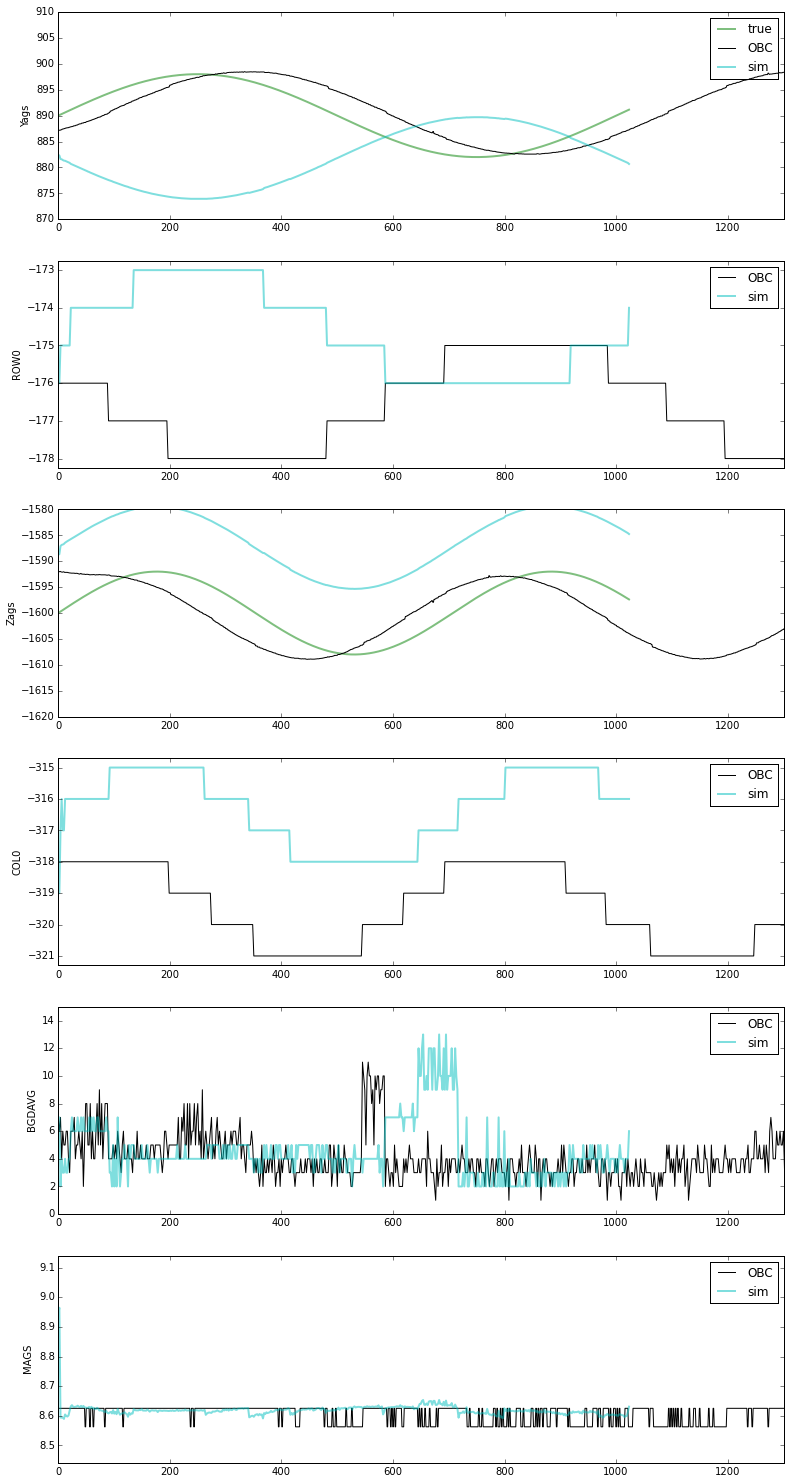

In [67]:
plt.figure(figsize=(13, 26))

plt.subplot(6, 1, 1)

plt.plot(guide['time'], guide['true_yags'], 'g', lw=2, alpha=0.5, label='true')
plt.plot(obc.yags.times - obc.yags.times[0], obc.yags.vals, 'k', label='OBC')
plt.plot(guide['time'], guide['aca_yags'], 'c', lw=2, alpha=0.5, label='sim')
plt.legend()
plt.ylabel('Yags')
plt.xlim(0, 1300)
plt.ylim(yag - 20, yag + 20);

plt.subplot(6, 1, 2)

plt.plot(obc.times - obc.times[0], obc.row0s, 'k', label='OBC')
plt.plot(guide['time'], guide['row0s'], 'c', lw=2, alpha=0.5, label='sim')
plt.legend()
plt.ylabel('ROW0')
plt.xlim(0, 1300)
plt.margins(0.05);

plt.subplot(6, 1, 3)

plt.plot(guide['time'], guide['true_zags'], 'g', lw=2, alpha=0.5)
plt.plot(obc.zags.times - obc.zags.times[0], obc.zags.vals, 'k')
plt.plot(guide['time'], guide['aca_zags'], 'c', lw=2, alpha=0.5)
plt.ylabel('Zags')
plt.xlim(0, 1300)
plt.ylim(zag - 20, zag + 20);

plt.subplot(6, 1, 4)

plt.plot(obc.times - obc.times[0], obc.col0s, 'k', label='OBC')
plt.plot(guide['time'], guide['col0s'], 'c', lw=2, alpha=0.5, label='sim')
plt.legend()
plt.ylabel('COL0')
plt.xlim(0, 1300)
plt.margins(0.05);

plt.subplot(6, 1, 5)

plt.plot(obc.times - obc.times[0], obc.bgdavgs, 'k', label='OBC')
plt.plot(guide['time'], guide['bgdavgs'], 'c', lw=2, alpha=0.5, label='sim')
plt.ylabel('BGDAVG')
plt.legend()
plt.xlim(0, 1300)
plt.ylim(0, 15);

plt.subplot(6, 1, 6)

plt.plot(obc.mags.times - obc.mags.times[0], obc.mags.vals, 'k', label='OBC')
plt.plot(guide['time'], guide['aca_mags'], 'c', lw=2, alpha=0.5, label='sim')
plt.ylabel('MAGS')
plt.legend()
plt.xlim(0, 1300)
plt.ylim(mag - 0.2, mag + 0.5);

__Figure.__<br>
* Simulated yags and row0s are 'reflected' with respect to the telemetry.
* Simulations (cyan) appear to be shifted in time with respect to OBC telemetry.
* Simulated row0s/col0s are off by 2-3px from the telemetered values.
* This is either due to a bug (offset is comparable to half size of a 6x6 image) or due to tracking a single star (no update to the attitude due to tracking stars in all slots?).
* Simulated yags/zags (cyan) are off from true yags/zags (green, derived by evolving catalog yag, zag, quat) by 7-18 arcsec ~ 1.5-3.5 pixels (see the first simulated image).